In [7]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from scipy import ndimage, spatial
from scipy.stats import multivariate_normal
import numpy.linalg as LA
import copy

array_of_img = [] # Store all the image data
# Read directory function
def read_directory(directory_name):
    filenumber = len([name for name in os.listdir(directory_name) if os.path.isfile(os.path.join(directory_name, name))])
    for i in range(1,filenumber+1):
        file = directory_name + "/" + str(i)+".jpg"
        img = cv2.imread(file)
        array_of_img.append(img)


In [8]:
def base_line(dirname):
    read_directory(dirname)
    
    imageB = array_of_img[0]
    imageA = array_of_img[1]
    
    (kpsA, featuresA) = detectAndDescribe(imageA)
    (kpsB, featuresB) = detectAndDescribe(imageB)
    
    # match features between the two images
    M = matchKeypoints(kpsA, kpsB, featuresA, featuresB)
    
    if M is None:
        return None

    (matches, H, status) = M
    vis = drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
    
    result = cv2.warpPerspective(imageA, H,
        (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
    result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
    
    
    plt.figure()
    plt.imshow(result)
    plt.figure()
    plt.imshow(vis)    

In [9]:
def detectAndDescribe(image):
        # convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
        descriptor = cv2.xfeatures2d.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(image, None)
        
        imkp=cv2.drawKeypoints(image,kps, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
#         plt.figure()
#         plt.imshow(imkp)
 
        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])
        # return a tuple of keypoints and features
        return (kps, features)

In [10]:
def matchKeypoints(kpsA, kpsB, featuresA, featuresB):
        # compute the raw matches and initialize the list of actual
        # matches
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []

        # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each
            # other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * 0.8:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,5.0)

            # return the matches along with the homograpy matrix
            # and status of each matched point
            return (matches, H, status)

        # otherwise, no homograpy could be computed
        return None

In [11]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
#     initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # only process the match if the keypoint was successfully
        # matched
        if s == 1:
            # draw the match
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

    # return the visualization
    return vis

('cv version: ', '3.4.2')


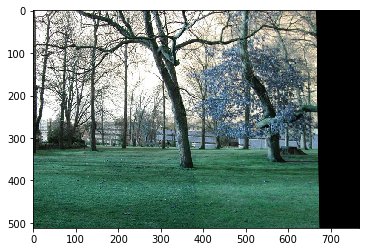

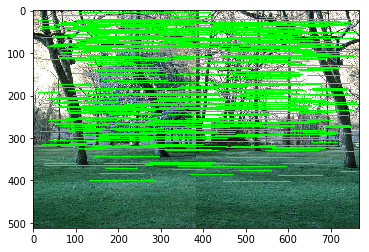

In [12]:
f = open('testfile.txt', 'r')
dirname = str(f.readline()).strip()
print('cv version: ', cv2.__version__)

while(dirname):
    base_line(dirname)
#     plt.figure()
#     plt.imshow(imageout)
    
#     cv2.imwrite(dirname+'.jpg', imageout)
    dirname = str(f.readline()).strip()